### Description

#### Evaluates a number of estimators to construct the Voting Regressor meta-estimator with weights such that the mean squared error of the combined predictions of the estimators is minimized.

#### version: 1.1

#### TODO:
- remove unused imports
- save final voting regressor
- plot results
- general file cleanup

### Done:
- prune features
- full db integration
- finalize estimator selection
- estimator comp. df
- finalize 'fine tuning'
- save final estimators

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Data split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import HuberRegressor


# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy import stats

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from config import db_password

## Interface with Database and create DataFrames

In [2]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [3]:
# Create Connection Engine

engine = create_engine(db_string)

In [4]:
# map to Base to extract metadata
Base = automap_base()
Base.prepare(engine, reflect=True)

In [11]:
# List of tables corresponding to cities
table_names = []
city_list = ['austin','boston','sanfran','chandler','chicago','houston','la','pittsburgh','spokane']

# Group by city population
# To generalize, pop groups can be calc. based on population of known cities in groups.
low_list = ['chandler', 'pittsburgh', 'spokane']
mid_list = ['austin', 'boston', 'sf']
high_list = ['chicago', 'la', 'houston']

for k in Base.metadata.tables.keys():
    if k in city_list:
        table_names.append(k)

print(table_names)

['austin', 'sanfran', 'la', 'boston', 'chandler', 'pittsburgh', 'houston', 'spokane', 'chicago']


In [15]:
# Create df from comb. of all city tables

def city_df(eng,city_tables,lowpop_list=[],midpop_list=[],highpop_list=[]):
    
    all_pop = pd.DataFrame()
    
    for city in city_tables:
        
        if city in lowpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 1
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in midpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 2
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in highpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 3
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
               
    return all_pop

In [16]:
all_pop = city_df(eng=engine,city_tables=table_names,lowpop_list=low_list,
                  midpop_list=mid_list,highpop_list=high_list)
all_pop.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
0,1191,1,600.0,1.0,5,1,2
1,1425,1,526.0,1.0,5,1,2
2,1266,1,578.0,1.0,5,1,2
3,1144,1,351.0,1.0,8,1,2
4,1775,4,1236.0,2.0,8,1,2


In [17]:
# Write to csv to prevent constant db calls
all_pop.to_csv('all_pop.csv')

In [ ]:
# Build df from csv if needed
# all_pop = pd.read_csv('all_pop.csv')

## Examine data

In [18]:
all_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
count,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000
mean,1842.516849,1.674403,939.883731,1.462174,5.571301,5.198393,1.950904
std,935.202674,0.942777,494.403762,0.633749,1.864343,2.632753,0.867467
min,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1300.000000,1.000000,680.000000,1.000000,4.000000,3.000000,1.000000
50%,1653.000000,2.000000,875.000000,1.000000,6.000000,5.000000,2.000000
75%,2201.000000,2.000000,1114.000000,2.000000,7.000000,7.000000,3.000000
max,20000.000000,8.000000,15492.000000,5.000000,11.000000,9.000000,3.000000


In [19]:
# Check dtypes
all_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4481 entries, 0 to 362
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4481 non-null   int64  
 1   bedroom        4481 non-null   int64  
 2   sqft           4481 non-null   float64
 3   bathroom       4481 non-null   float64
 4   amenity_count  4481 non-null   int64  
 5   cityid         4481 non-null   int64  
 6   pop_class      4481 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 280.1 KB


In [20]:
all_t = all_pop.copy()

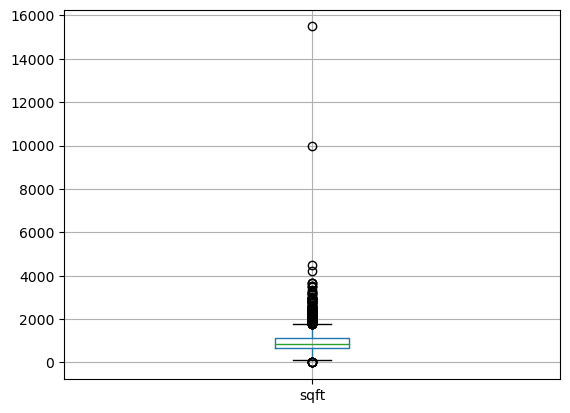

In [21]:
# Dist of num ft 'sqft' -> appears many outside 1.5*IQR
all_t.boxplot(column='sqft')
plt.show()

In [22]:
# Calc iqr of sqft and upper/lower bounds
sqft_iqr = all_t.sqft.quantile(.75)-all_t.sqft.quantile(.25)
upper = 1.5*sqft_iqr + all_t.sqft.quantile(.75)
lower =  all_t.sqft.quantile(.25) - 1.5*sqft_iqr
print(lower)
print(upper)

29.0
1765.0


In [23]:
all_t.drop(all_t[all_t.sqft > upper].index, inplace=True)

## Split Train and Test Data

In [24]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_t, all_t['cityid']):
    strat_train_set = all_t.iloc[train_index]
    strat_test_set = all_t.iloc[test_index]

In [25]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Repeat for test set
all_test = strat_test_set.copy()

# Show first 5 rows of training set
all_train.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
203,975,1,1000.0,1.0,3,6,3
13,1721,2,1037.0,2.0,5,1,2
15,1651,2,1003.0,2.0,7,5,1
425,2480,2,860.0,1.5,7,3,3
555,2942,1,800.0,1.0,5,3,3


In [26]:
# Compare Train Test Split
train_set,test_set = train_test_split(all_t, test_size=0.2, random_state=42)

In [27]:
# df for comparison of test sets
split_comp = pd.DataFrame()
split_comp['Overall'] = all_t.cityid.value_counts() / len(all_t.cityid)
split_comp['Strat_City'] = all_test.cityid.value_counts() / len(all_test.cityid)
split_comp['Random'] = test_set.cityid.value_counts() / len(test_set.cityid)
split_comp['Random %Error'] = ((split_comp.Random - split_comp.Overall) / split_comp.Overall)*100
split_comp['Strat_City %Error'] = ((split_comp.Strat_City - split_comp.Overall) / split_comp.Overall)*100
split_comp

,Overall,Strat_City,Random,Random %Error,Strat_City %Error
5,0.159666,0.159226,0.150298,-5.867704,-0.275686
1,0.154007,0.154762,0.186012,20.781811,0.490467
3,0.153709,0.153274,0.153274,-0.282911,-0.282911
9,0.152517,0.153274,0.148810,-2.430943,0.496129
7,0.115877,0.116071,0.113095,-2.400845,0.167554
8,0.092940,0.092262,0.084821,-8.735405,-0.729739
4,0.091749,0.092262,0.089286,-2.684369,0.559485
6,0.079535,0.078869,0.074405,-6.450642,-0.837681


#### Stratified Shuffle Split demonstrates better representation of the population groupings

In [28]:
# Drop columns not used in analysis
all_train.drop(columns=['cityid'],axis=1,inplace=True)
all_test.drop(columns=['cityid'],axis=1,inplace=True)

### Preprocess Finalized Feature Set

In [29]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = all_train.price.values

X_test = all_test.drop(columns='price').values
y_test = all_test.price.values

In [30]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [31]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [32]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_score = score_info(gbr_cvs)

Mean: 355769.36000054405
STD: 52978.9990020398
Conf. Interval: (325400.8254039786, 386137.8945971095)


In [33]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_score =score_info(rfr_cvs)

Mean: 326005.2638859776
STD: 72901.13005025653
Conf. Interval: (284216.9981247711, 367793.5296471841)


In [34]:
# Lasso

lasso_cvs = cross_val_score(LassoCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_score=score_info(lasso_cvs)

Mean: 446691.07682943344
STD: 69964.75477022446
Conf. Interval: (406585.9952725325, 486796.15838633437)


In [35]:
# Ridge

ridge_cvs = cross_val_score(RidgeCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_score=score_info(ridge_cvs)

Mean: 447200.4761193795
STD: 70046.35247513892
Conf. Interval: (407048.62126038957, 487352.33097836946)


In [36]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_score=score_info(ada_cvs)

Mean: 507996.3089632121
STD: 72769.34578370738
Conf. Interval: (466283.5843623403, 549709.033564084)


In [37]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_score=score_info(ard_cvs)

Mean: 445986.2305490941
STD: 70177.43360575542
Conf. Interval: (405759.2375801914, 486213.2235179968)


In [38]:
# SVM with polynomial kernel

svp_cvs = cross_val_score(SVR(kernel='poly'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svp_score = score_info(svp_cvs)

Mean: 586707.4953258284
STD: 77625.73222621449
Conf. Interval: (542211.0008827236, 631203.9897689333)


In [39]:
svl_cvs = cross_val_score(SVR(kernel='linear'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svl_score = score_info(svl_cvs)

Mean: 523632.53834111884
STD: 76202.80161823277
Conf. Interval: (479951.6938387639, 567313.3828434737)


In [40]:
svr_cvs = cross_val_score(SVR(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svr_score = score_info(svr_cvs)

Mean: 603117.8905392821
STD: 83700.19491324002
Conf. Interval: (555139.4025941978, 651096.3784843665)


In [41]:
svs_cvs = cross_val_score(SVR(kernel='sigmoid'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svs_score = score_info(svs_cvs)

Mean: 575688.9606064855
STD: 81212.26209811354
Conf. Interval: (529136.6014141771, 622241.3197987939)


In [42]:
# K nearest regression

knn_cvs = cross_val_score(KNeighborsRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

knn_score = score_info(knn_cvs)

Mean: 373307.63141899445
STD: 68298.93165308778
Conf. Interval: (334157.43024710374, 412457.83259088517)


In [43]:
bag_cvs = cross_val_score(BaggingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

bag_score= score_info(bag_cvs)

Mean: 344931.8027452563
STD: 79618.6982207739
Conf. Interval: (299292.90361547127, 390570.7018750413)


In [44]:
hbr_cvs = cross_val_score(HuberRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

huber_score = score_info(hbr_cvs)

Mean: 453606.95219848765
STD: 73403.13581204064
Conf. Interval: (411530.9275208881, 495682.9768760872)


In [45]:
mod_type = ['Tree','Tree','Lin','Lin','Tree','Lin','Poly','Lin',
                       'RBF','Logistic','Cluster','Tree','Lin']
est_pre = pd.DataFrame([gbr_score,rfr_score,lasso_score,ridge_score,
                       ada_score,ard_score,svp_score,svl_score,
                        svr_score,svs_score,knn_score,bag_score,huber_score],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Lasso','Ridge','AdaB','ARD','SVR(Poly)',
                              'SVR(rbf)','SVR(linear)','SVR(sigmoid)','Knearest',
                             'Bagging(tree)','Huber'])
est_pre['Model_Type'] = mod_type

In [46]:
est_pre.sort_values(by=['Mean MSE','Stdev MSE'])

,Mean MSE,Stdev MSE,CI Low,CI High,Model_Type
RFR,326005.263886,72901.130050,284216.998125,367793.529647,Tree
Bagging(tree),344931.802745,79618.698221,299292.903615,390570.701875,Tree
GBR,355769.360001,52978.999002,325400.825404,386137.894597,Tree
Knearest,373307.631419,68298.931653,334157.430247,412457.832591,Cluster
ARD,445986.230549,70177.433606,405759.237580,486213.223518,Lin
Lasso,446691.076829,69964.754770,406585.995273,486796.158386,Lin
Ridge,447200.476119,70046.352475,407048.621260,487352.330978,Lin
Huber,453606.952198,73403.135812,411530.927521,495682.976876,Lin
AdaB,507996.308963,72769.345784,466283.584362,549709.033564,Tree
SVR(rbf),523632.538341,76202.801618,479951.693839,567313.382843,Lin


#### Best 8 Models by MSE
- RFR (Tree)
- Bagging (Tree)
- GBR (Tree)
- Knearest (cluster)
- ARD (lin)
- Lasso (lin)
- Ridge (lin)
- Huber (lin)

#### Not significant variation in model type as desired

## Estimator Tuning

In [47]:
def mod_imp(model):
    scores = cross_val_score(model,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)
    
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [54]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': np.arange(.25,.35,.01),
    'n_estimators': np.arange(8,14),
    'subsample': np.arange(.93,.97,.005),
    'max_depth': np.arange(7,12),
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-30]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

gbr_imp = mod_imp(gbr)

Fitting 15 folds for each of 2400 candidates, totalling 36000 fits
Mean: 315485.2577528823
STD: 70780.91042752899
Conf. Interval: (274912.34079361596, 356058.17471214867)


In [56]:
# Save Tuned Model
joblib.dump(gbr,'mod_params/gbr.pkl')

['mod_params/gbr.pkl']

In [57]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(20,40),
    'random_state': [42],
    'max_features': ['sqrt']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

rfr_imp = mod_imp(rfr)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
Mean: 322066.22454159067
STD: 73874.8489300077
Conf. Interval: (279719.8052470206, 364412.6438361607)


In [60]:
joblib.dump(rfr,'mod_params/rfr.pkl')

['mod_params/rfr.pkl']

In [61]:
# Bagging

model = BaggingRegressor(random_state=42,n_jobs=-1)


mod_params = {
    'n_estimators': np.arange(1,50)
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
bag = model_cv.best_estimator_

bag_imp = mod_imp(bag)

Fitting 15 folds for each of 49 candidates, totalling 735 fits
Mean: 326570.54160154733
STD: 70998.63642229642
Conf. Interval: (285872.8201059701, 367268.2630971246)


In [63]:
joblib.dump(bag,'mod_params/bag.pkl')

['mod_params/bag.pkl']

In [90]:
# ARD

model = ARDRegression(n_iter=1000)


mod_params = {
    'alpha_1': [1e-50,1e-25],
    'alpha_2': [1e-50],
    'lambda_1': [1e-50],
    'lambda_2': [1e-50]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ard = model_cv.best_estimator_

ard_imp = mod_imp(ard)

Fitting 15 folds for each of 2 candidates, totalling 30 fits
Mean: 445986.1916653749
STD: 70177.42036099994
Conf. Interval: (405759.20628860913, 486213.1770421407)


In [91]:
joblib.dump(ard,'mod_params/ard.pkl')

['mod_params/ard.pkl']

In [94]:
lasso = LassoCV(n_alphas=1000,max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)
lasso_imp = mod_imp(lasso)

Mean: 446585.68210452195
STD: 69910.8962257932
Conf. Interval: (406511.47325380065, 486659.89095524326)


In [95]:
joblib.dump(lasso,'mod_params/lasso.pkl')

['mod_params/lasso.pkl']

In [96]:
ridge = RidgeCV(alphas=[1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2],cv=15)
ridge_imp = mod_imp(ridge)

Mean: 447200.4761193869
STD: 70046.35247513468
Conf. Interval: (407048.6212603994, 487352.3309783744)


In [97]:
joblib.dump(ridge,'mod_params/ridge.pkl')

['mod_params/ridge.pkl']

In [100]:
# KNN

model = KNeighborsRegressor(n_jobs=-1)


mod_params = {
    'n_neighbors': np.arange(10,40,1),
    'weights': ['distance'],
    'p': [1]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
knn = model_cv.best_estimator_

knn_imp = mod_imp(knn)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Mean: 326619.84599890123
STD: 70007.19125805196
Conf. Interval: (286490.43906830467, 366749.2529294978)


In [102]:
joblib.dump(knn,'mod_params/knn.pkl')

['mod_params/knn.pkl']

In [109]:
# Huber

model = HuberRegressor(max_iter=1000)


mod_params = {
    'epsilon': np.arange(10.5,11.5,.001),
    'alpha': [.01]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
huber = model_cv.best_estimator_

huber_imp = mod_imp(huber)

Fitting 15 folds for each of 1000 candidates, totalling 15000 fits
Mean: 447194.2585501963
STD: 70150.76189864255
Conf. Interval: (406982.5542933392, 487405.9628070534)


In [111]:
joblib.dump(huber,'mod_params/huber.pkl')

['mod_params/huber.pkl']

In [114]:
est_post = pd.DataFrame([gbr_imp,rfr_imp,bag_imp,ard_imp,lasso_imp,ridge_imp,
                       knn_imp,huber_imp],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Bagging(tree)','ARD','Lasso','Ridge',
                              'Knearest','Huber'])
est_post

,Mean MSE,Stdev MSE,CI Low,CI High
GBR,315485.257753,70780.910428,274912.340794,356058.174712
RFR,322066.224542,73874.848930,279719.805247,364412.643836
Bagging(tree),326570.541602,70998.636422,285872.820106,367268.263097
ARD,445986.191665,70177.420361,405759.206289,486213.177042
Lasso,446585.682105,69910.896226,406511.473254,486659.890955
Ridge,447200.476119,70046.352475,407048.621260,487352.330978
Knearest,326619.845999,70007.191258,286490.439068,366749.252929
Huber,447194.258550,70150.761899,406982.554293,487405.962807


In [ ]:
# Load Models if needed
# gbr = joblib.load('model_params/gbr')
# rfr = joblib.load('model_params/rfr')
# bag = joblib.load('model_params/bag')
# ard = joblib.load('model_params/ard')
# lasso = joblib.load('model_params/lasso')
# ridge = joblib.load('model_params/ridge')
# knn = joblib.load('model_params/knn')
# huber = joblib.load('model_params/huber')

In [112]:
# Fit Estimators
gbr.fit(X_train_scaled,y_train)
rfr.fit(X_train_scaled,y_train)
bag.fit(X_train_scaled,y_train)
ard.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)
knn.fit(X_train_scaled,y_train)
huber.fit(X_train_scaled,y_train)

HuberRegressor(alpha=0.01, epsilon=10.891999999999783, max_iter=1000)

## Weighted VotingRegressor

### Minimize MSE of models

In [115]:
# Specify number of estimators
n_est = 8

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [137]:
# Create vector of predicted values from each estimator
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
bag_pred= bag.predict(X_test_scaled)
ard_pred = ard.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)
knn_pred = knn.predict(X_test_scaled)
huber_pred = huber.predict(X_test_scaled)

In [138]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((gbr_pred,rfr_pred,bag_pred,ard_pred,lasso_pred,ridge_pred,
                            knn_pred,huber_pred))

In [139]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [140]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [141]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 28090972.007207327
     jac: array([-14193612.75, -14394165.25, -14205564.5 , -11347193.  ,
       -11287047.75, -11298535.5 , -15099691.5 , -11311091.5 ])
 message: 'Optimization terminated successfully'
    nfev: 559
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([1.99605696e-01, 2.43264919e-01, 1.87749811e-02, 2.25386470e-01,
       4.83958047e-03, 5.80451843e-07, 2.75720974e-01, 3.24067987e-02])

In [142]:
optimal_mod_weights = res.x

In [143]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([5, 7, 3, 6, 2, 1, 8, 4], dtype=int64)

### Create VotingRegressor with new weights

In [144]:
estimators = [('gbr',gbr),('rfr',rfr),('bag',bag),('ard',ard),('lasso',lasso),('ridge',ridge),
            ('knn',knn),('huber',huber)]


vrg = VotingRegressor(estimators,
                     weights=scaled_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.26,
                                                       max_depth=11,
                                                       max_features='sqrt',
                                                       n_estimators=9,
                                                       random_state=42,
                                                       subsample=0.9400000000000001)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=34,
                                                   random_state=42)),
                            ('bag',
                             BaggingRegressor(n_estimators=49, n_jobs=-1,
                                              random_state=42)),
                            ('ard',
                             ARDRe...
                             LassoCV(cv=15, max_iter=5000, n_alphas=1000,
                                     n_jobs=-1, random_state=42)),
                            ('ridge',
                             RidgeCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                             10.0, 100.0],
                                     cv=15)),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=30, p=1,
                                                 weights='distance')),
                            ('huber',
                             HuberRegressor(alpha=0.01,
                                            epsilon=10.891999999999783,
                                            max_iter=1000))],
                n_jobs=-1,
                weights=array([5, 7, 3, 6, 2, 1, 8, 4], dtype=int64))

In [145]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score = score_info(vrg_cvs)

Mean: 313593.68991384096
STD: 62866.12170222055
Conf. Interval: (277557.6751187658, 349629.70470891614)


In [146]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.8042719235349022
Testing Score: 0.5115366101479897
